This simulates the Viscek model for the creation of traffic jams.  Cars are defined by their position (x), as well as their velocity (x); the cars all travel on the straight line.

For an arbitrary state, one update of the system consists of the following four steps, performed in parallel for all vehicles:

The birds move according to the following rules:
1. Acceleration: if the velocity $v$ of a vehicle is lower than $v_{\max}$ and if the distance to the car ahead is larger than $v + 1$, increase the speed by one $[v\to v +1]$.
2.  Deceleration: if a vehicle at site $i$ sees the next vehicle at site $i + j$ with $j\leq v$, it reduces its speed to $j-1[v\rightarrow j-1]$.
3. Randomisation: with probability $p$, the vehicles velocity is decreased by one to a minimum of zero $[v\to \max(v-1,0)]$.
4. Each vehicle is advanced v sites.
5. Initialisation: if a vehicle reaches site $R$, the end of the road, it is removed from the grid. To replace it, a new vehicle is initialised with a random velocity between $1$ and the speed of the first vehicle on the road. This is to ensure that it doesn't crash or overtake a car when it joins the stretch of road that we are examining and a car cannot join a road with velocity 0. The vehicle is placed on the road at a random site between $0$ and its velocity as that is the maximum distance it will be travel in one time step.
6. Lane change: if a vehicle at site $i$ with velocity $v$ sees the vehicle ahead at site $i+j$ with $j \leq v$, attempt to change lanes to one of the adjacent lanes. This can occur if there exists an adjacent lane with a vehicle ahead on site $i+k$ with a velocity $v_{a}$ such that $v_{a} + k > v$, and a vehicle behind on site $i-l$ with velocity $v_{b}$ such that $v_{b} + l < v$.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Simulation parameters
L = 100         # Length of the road
num_cars = 50   # Number of cars
num_lanes = 3   # Number of lanes
vmax = 5        # Maximum speed
p = 0.1         # Probability of random deceleration

def initialize_cars(N, L, num_lanes):
    '''
    Initialize car positions, velocities, lanes, and colors.
    '''
    car_positions = np.sort(np.random.choice(range(L), N, replace=False))  # Ensure unique positions
    car_velocities = np.random.randint(1, vmax + 1, size=N)  # Random initial velocities between 1 and vmax
    car_lanes = np.random.choice(range(num_lanes), N)  # Randomly assign each car to a lane
    #car_colors = np.random.rand(N, 3)  # Random colors for each car (RGB)
    car_colors = plt.cm.rainbow(np.linspace(0, 1, num_cars))  # Generate unique colors for each car
    return car_positions, car_velocities, car_lanes, car_colors

def next_distance(car_positions, car_lanes, pos, L):
    '''
    Finds the distance to the next car in the same lane.
    '''
    N = len(car_positions)
    current_lane = car_lanes[pos]
    
    # Loop to find the next car in the same lane
    for i in range(1, N):
        next_car_idx = (pos + i) % N
        if car_lanes[next_car_idx] == current_lane:
            distance = ((car_positions[next_car_idx] - car_positions[pos] - 1) % L)-1
            return distance
    return L  # Return max distance if no car is in front in the same lane

def update_velocity(car_positions, car_velocities, car_lanes, vmax, p):
    '''
    Update velocities of cars based on traffic rules.
    '''
    N = len(car_positions)

    # Step 1: Acceleration
    for i in range(N):
        if car_velocities[i] < vmax:
            distance_to_next = next_distance(car_positions, car_lanes, i, L)
            if distance_to_next > car_velocities[i]:
                car_velocities[i] += 1

    # Step 2: Deceleration
    for i in range(N):
        distance_to_next = next_distance(car_positions, car_lanes, i, L)
        if car_velocities[i] > distance_to_next:
            car_velocities[i] = distance_to_next + 1

    # Step 3: Randomisation
    for i in range(N):
        if np.random.rand() < p:
            car_velocities[i] = max(car_velocities[i] - 1, 0)

    # Step 4: If velocity is at 0 and there is no car in front, increase velocity to 1 as no point being standstill on motorway
    for i in range(N):
        distance_to_next = next_distance(car_positions, car_lanes, i, L)
        if car_velocities[i] == 0 and distance_to_next > 1:
            car_velocities[i] = 1

    return car_velocities

def apply_boundary_conditions(car_positions, car_velocities, car_lanes, L):
    '''
    Remove cars that reach the end of the road and replace them with new cars at position 0.
    '''
    for i in range(len(car_positions)):
        if car_positions[i] >= L:  # Check if car is beyond the boundary
            # Find the car in front to set a speed limit for the new car
            distance_to_next = next_distance(car_positions, car_lanes, i, L)
            front_car_velocity = car_velocities[(i + 1) % len(car_velocities)]
            new_velocity = np.random.randint(1, front_car_velocity + 1) if front_car_velocity > 0 else 1
            new_position = np.random.randint(0, min(distance_to_next, new_velocity)) if distance_to_next > 0 else 0
            # new_lane = np.random.randint(0, num_lanes)

            # Replace the car with the new position, lane, and velocity
            car_positions[i] = new_position
            car_velocities[i] = new_velocity
            # car_lanes[i] = new_lane

    return car_positions, car_velocities, car_lanes

def update_positions(car_positions, car_velocities, car_lanes, L):
    '''
    Update car positions based on their velocities and apply boundary conditions.
    '''
    car_positions = (car_positions + car_velocities)  # Update positions
    car_positions, car_velocities, car_lanes = apply_boundary_conditions(car_positions, car_velocities, car_lanes, L)
    return car_positions, car_velocities, car_lanes  

def sort(car_positions, car_velocities, car_lanes):
    sorted_indices = np.argsort(np.abs(car_positions))
    
    sorted_carpos = car_positions[sorted_indices]
    sorted_carvel = car_velocities[sorted_indices]
    sorted_carlan = car_lanes[sorted_indices]

    return sorted_carpos, sorted_carvel, sorted_carlan


def separate_by_lane(car_positions, car_velocities, car_lanes, car_colors):
    lane_0_pos = []
    lane_0_vel = []
    lane_0_col = []
    lane_1_pos = []
    lane_1_vel = []
    lane_1_col = []
    lane_2_pos = []
    lane_2_vel = []
    lane_2_col = []
    for index, lane in enumerate(car_lanes):
        if lane == 0:
            lane_0_pos.append(car_positions[index])
            lane_0_vel.append(car_velocities[index])
            lane_0_col.append(car_colors[index])
        elif lane == 1:
            lane_1_pos.append(car_positions[index])
            lane_1_vel.append(car_velocities[index])
            lane_1_col.append(car_colors[index])
        else:
            lane_2_pos.append(car_positions[index])
            lane_2_vel.append(car_velocities[index])
            lane_2_col.append(car_colors[index])

    return lane_0_pos, lane_0_vel, lane_0_col, lane_1_pos, lane_1_vel, lane_1_col, lane_2_pos, lane_2_vel, lane_2_col

def lane_change(car_positions, car_velocities, car_lanes):
    '''
    Handle lane changes based on the safety and benefit criteria.
    Cars may change to a neighboring lane if it's safe and improves travel conditions.
    '''
    N = len(car_positions)
    
    for i in range(N):
        current_lane = car_lanes[i]
        current_pos = car_positions[i]
        current_velocity = car_velocities[i]

        # Check neighboring lanes for lane change possibilities
        for delta_lane in [-1, 1]:  # Check lane -1 (left) and lane +1 (right)
            target_lane = current_lane + delta_lane

            if 0 <= target_lane < num_lanes:  # Ensure target lane is valid
                # Get positions and velocities of cars in the target lane
                target_lane_positions = car_positions[car_lanes == target_lane]
                target_lane_velocities = car_velocities[car_lanes == target_lane]

                # Find the closest car in front and behind in the target lane
                cars_front = [pos for pos in target_lane_positions if pos >= current_pos]
                cars_behind = [pos for pos in target_lane_positions if pos < current_pos]
                car_front = min(cars_front, default=None)
                car_behind = max(cars_behind, default=None)

                # Calculate safety distances
                safe_distance_front = float('inf') if car_front is None else car_front - current_pos
                safe_distance_behind = -float('inf') if car_behind is None else current_pos - car_behind

                # Get velocities of the closest cars
                velocity_front = float('inf') if car_front is None else target_lane_velocities[np.where(target_lane_positions == car_front)[0][0]]
                velocity_behind = -float('inf') if car_behind is None else target_lane_velocities[np.where(target_lane_positions == car_behind)[0][0]]

                # can_move = [True for pos in target_lane_positions if safe_distance_behind + velocity_behind < current_velocity and safe_distance_front + velocity_front < current_velocity]

                if (
                    safe_distance_behind < current_velocity + 1 and  # Enough space behind
                    safe_distance_front > current_velocity # Enough space in front
                ):
                    car_lanes[i] = target_lane  # Change to the target lane
                    break  # Exit loop as lane change is complete

    return car_velocities, car_lanes

def step(car_positions, car_velocities, car_lanes, L, vmax, p):
    '''
    Perform a single time step update: update velocities, change lanes, and positions.
    '''
    car_velocities, car_lanes = lane_change(car_positions, car_velocities, car_lanes)
    car_velocities = update_velocity(car_positions, car_velocities, car_lanes, vmax, p)
    car_positions, car_velocities, car_lanes = update_positions(car_positions, car_velocities, car_lanes, L)
    return car_positions, car_velocities, car_lanes

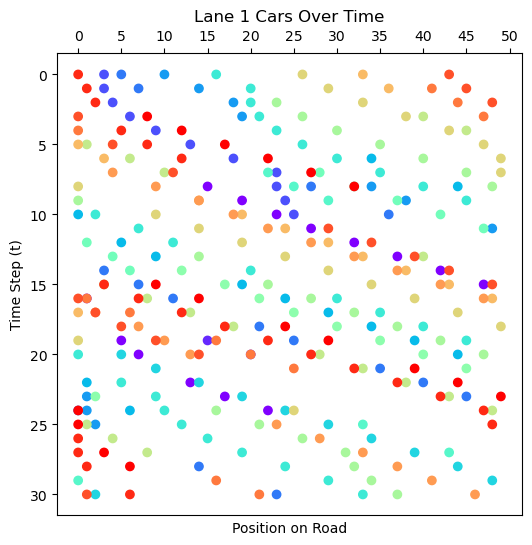

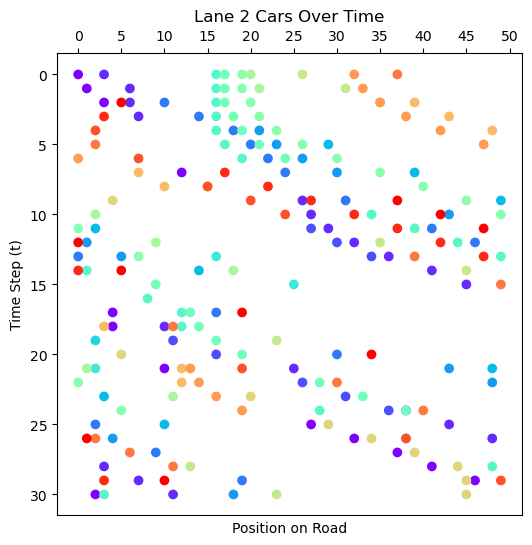

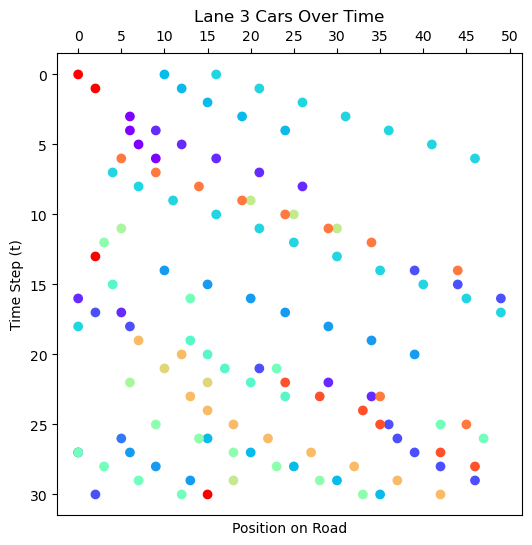

In [5]:
np.random.seed(4521)

lane_positions0 = []
lane_positions1 = []
lane_positions2 = []
lane_colors0 = []
lane_colors1 = []
lane_colors2 = []

# Simulation parameters
L = 50         # Length of the road
num_cars = 20   # Number of cars
num_lanes = 3   # Number of lanes
vmax = 5        # Maximum speed
p = 0.1         # Probability of random deceleration

def animate(i_step):
    global car_positions, car_velocities, car_lanes
    car_positions, car_velocities, car_lanes = step(car_positions, car_velocities, car_lanes, L, vmax, p)
    #car_positions, car_velocities, car_lanes = sort(car_positions, car_velocities, car_lanes)
    lane_0_pos, lane_0_vel, lane_0_col, lane_1_pos, lane_1_vel, lane_1_col, lane_2_pos, lane_2_vel, lane_2_col = separate_by_lane(car_positions, car_velocities, car_lanes, car_colors)
    lane_positions0.append(lane_0_pos)
    lane_colors0.append(lane_0_col)
    lane_positions1.append(lane_1_pos)
    lane_colors1.append(lane_1_col)
    lane_positions2.append(lane_2_pos)
    lane_colors2.append(lane_2_col)

# Number of steps to animate - Change this if you want for a longer timeframe
n_steps = 31

car_positions, car_velocities, car_lanes, car_colors = initialize_cars(num_cars, L, num_lanes)

# Run the animation
for i_step in range(n_steps):
    animate(i_step)

#print(lane_positions)

# Plotting
plt.figure(figsize=(6, 6))
for t, positions in enumerate(lane_positions0):
    plt.scatter(positions, [t] * len(positions), label=f't={t}' if t == 0 else "", color=lane_colors0[t])

plt.title("Lane 1 Cars Over Time")
plt.ylabel("Time Step (t)")
plt.xlabel("Position on Road")
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, L+1, 5))
plt.savefig('lanechange1')
plt.show()

# Plotting
plt.figure(figsize=(6, 6))
for t, positions in enumerate(lane_positions1):
    plt.scatter(positions, [t] * len(positions), label=f't={t}' if t == 0 else "", color=lane_colors1[t])

plt.title("Lane 2 Cars Over Time")
plt.ylabel("Time Step (t)")
plt.xlabel("Position on Road")
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, L+1, 5))
plt.savefig('lanechange1')
plt.show()

# Plotting
plt.figure(figsize=(6, 6))
for t, positions in enumerate(lane_positions2):
    plt.scatter(positions, [t] * len(positions), label=f't={t}' if t == 0 else "", color=lane_colors2[t])

plt.title("Lane 3 Cars Over Time")
plt.ylabel("Time Step (t)")
plt.xlabel("Position on Road")
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.gca().invert_yaxis()
plt.xticks(np.arange(0, L+1, 5))
plt.savefig('lanechange1')
plt.show()

MovieWriter Pillow unavailable; using Pillow instead.


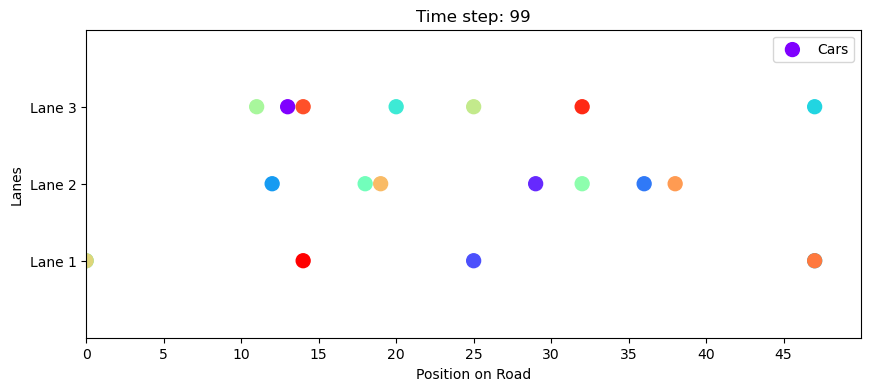

In [6]:
import matplotlib.animation as animation
from IPython.display import HTML

np.random.seed(1141)

# Initialize cars
car_positions, car_velocities, car_lanes, car_colors = initialize_cars(num_cars, L, num_lanes)

# Set up the figure for animation
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlim(0, L)
ax.set_ylim(-1, num_lanes)
ax.set_xticks(range(0, L, 5))  # Ticks at every 5 units for better visibility
ax.set_yticks(range(num_lanes))
ax.set_yticklabels([f"Lane {i+1}" for i in range(num_lanes)])
plt.xlabel("Position on Road")
plt.ylabel("Lanes")

# Initial scatter plot for cars with unique colors
scat = ax.scatter(car_positions, car_lanes, c=car_colors, s=100, label='Cars')
plt.legend()

# Function to update the plot at each time step
def animate(i_step):
    global car_positions, car_velocities, car_lanes
    car_positions, car_velocities, car_lanes = step(car_positions, car_velocities, car_lanes, L, vmax, p)
    scat.set_offsets(np.c_[car_positions, car_lanes])
    ax.set_title(f"Time step: {i_step}")
    return scat,  # Return the updated scatter plot for blitting

def init():
    scat.set_offsets(np.c_[car_positions, car_lanes])
    ax.set_title("Time step: 0")
    return scat,

# Create the animation with the initialization function
ani = animation.FuncAnimation(fig, animate, frames=100, init_func=init, interval=300, blit=True)

ani.save('/home/jovyan/Industrial/animation.gif', writer='Pillow', fps=3)

# Display animation
HTML(ani.to_jshtml())